# Supervised Graph Learning Regularization

We will be creating a graph regularized version for a topic classification task. The task is to classify paper depending on their content. However in order to do so, we will also use the information encoded in the citation network that relates documents among each other. Of course, we do know that this kind of information is indeed powerful as papers belonging to the same subject tend to reference each other. For this task, we will be using the Cora dataset available in the stellargraph library.

In [ ]:
!pip install -q stellargraph
!pip install -q neural_structured_learning

In [ ]:
from stellargraph import datasets

import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection

import tensorflow as tf
from tensorflow.data import Dataset

from tensorflow.train import Example, Features, Feature, Int64List, BytesList, FloatList
from tensorflow.keras.callbacks import TensorBoard

from functools import reduce
from typing import List, Tuple
import pandas as pd
import six

import neural_structured_learning as nsl

In [ ]:
dataset = datasets.Cora()
dataset.download()

In [ ]:
label_index = {
      'Case_Based': 0,
      'Genetic_Algorithms': 1,
      'Neural_Networks': 2,
      'Probabilistic_Methods': 3,
      'Reinforcement_Learning': 4,
      'Rule_Learning': 5,
      'Theory': 6,
  }

In [ ]:
G, labels = dataset.load()

We now create the Dataset object where we will both include information of the targeted sample (node) and its neighbors. In the following we will also allow to control the number of labelling instances to be used, in order to reproduce and evaluate the classification performance in a semi-supervised setting. 

In [ ]:
GRAPH_PREFIX="NL_nbr"

In [ ]:
def _int64_feature(*value):
    """Returns int64 tf.train.Feature from a bool / enum / int / uint."""
    return Feature(int64_list=Int64List(value=list(value)))

def _bytes_feature(value):
    """Returns bytes tf.train.Feature from a string."""
    return Feature(
        bytes_list=BytesList(value=[value.encode('utf-8')])
    )

def _float_feature(*value):
    return Feature(float_list=FloatList(value=list(value)))

In [ ]:
def addFeatures(x, y):
    res = Features()
    res.CopyFrom(x)
    res.MergeFrom(y)
    return res

def neighborFeatures(features: Features, weight: float, prefix: str):
    data = {f"{prefix}_weight": _float_feature(weight)}
    for name, feature in six.iteritems(features.feature):
        data[f"{prefix}_{name}"] = feature 
    return Features(feature=data)

def neighborsFeatures(neighbors: List[Tuple[Features, float]]):
    return reduce(
        addFeatures, 
        [neighborFeatures(sample, weight, f"{GRAPH_PREFIX}_{ith}") for ith, (sample, weight) in enumerate(neighbors)],
        Features()
    )

def getNeighbors(idx, adjMatrix, topn=5):
    weights = adjMatrix.loc[idx]
    return weights[weights>0].sort_values(ascending=False).head(topn).to_dict()
    

def semisupervisedDataset(G, labels, ratio=0.2, topn=5):
    n = int(np.round(len(labels)*ratio))
    
    labelled, unlabelled = model_selection.train_test_split(
        labels, train_size=n, test_size=None, stratify=labels
    )
    
    adjMatrix = pd.DataFrame.sparse.from_spmatrix(G.to_adjacency_matrix(), index=G.nodes(), columns=G.nodes())
    
    features = pd.DataFrame(G.node_features(), index=G.nodes())
    
    dataset = {
        index: Features(feature = {
            #"id": _bytes_feature(str(index)), 
            "id": _int64_feature(index),
            "words": _float_feature(*[float(x) for x in features.loc[index].values]), 
            "label": _int64_feature(label_index[label])
        })
        for index, label in pd.concat([labelled, unlabelled]).items()
    }
    
    trainingSet = [
        Example(features=addFeatures(
            dataset[exampleId], 
            neighborsFeatures(
                [(dataset[nodeId], weight) for nodeId, weight in getNeighbors(exampleId, adjMatrix, topn).items()]
            )
        ))
        for exampleId in labelled.index
    ]
    
    testSet = [Example(features=dataset[exampleId]) for exampleId in unlabelled.index]

    serializer = lambda _list: [e.SerializeToString() for e in _list]
    
    return serializer(trainingSet), serializer(testSet)

We split the dataset into a training set and a test set

In [ ]:
trainingSet, testSet = semisupervisedDataset(G, labels)

In [ ]:
vocabularySize = 1433

In [ ]:
neighbors=2
defaultWord = tf.constant(0, dtype=tf.float32, shape=[vocabularySize])

def parseExample(example, training=True):
    schema = {
        'words': tf.io.FixedLenFeature([vocabularySize], tf.float32, default_value=defaultWord),
        'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1)
    }
    
    if training is True:
        for i in range(neighbors):
            name = f"{GRAPH_PREFIX}_{i}"
            schema[f"{name}_weight"] = tf.io.FixedLenFeature([1], tf.float32, default_value=[0.0])
            schema[f"{name}_words"] = tf.io.FixedLenFeature([vocabularySize], tf.float32, default_value=defaultWord)
    
    features = tf.io.parse_single_example(example, schema)
    
    label = features.pop("label")
    return features, label

In [ ]:
def sampleGenerator(dataset):
    def wrapper():
        for example in dataset:
            yield example
    return wrapper
            
myTrain = Dataset \
    .from_generator(sampleGenerator(trainingSet), output_types=tf.string, output_shapes=()) \
    .map(lambda x: parseExample(x, True))

myTest = Dataset \
    .from_generator(sampleGenerator(testSet), output_types=tf.string, output_shapes=()) \
    .map(lambda x: parseExample(x, False))

In [ ]:
for features, labels in myTrain.batch(10).take(1):
    print(features)
    print(labels)

In [ ]:
for features, labels in myTest.batch(10).take(1):
    print(features)
    print(labels)

### Creating the model 

We now create the model that we will use to classify the documents

In [ ]:
layers = [50, 50]

In [ ]:
"""Creates a functional API-based multi-layer perceptron model."""
def create_model(num_units):
    inputs = tf.keras.Input(
          shape=(vocabularySize,), dtype='float32', name='words'
    )

    # outputs = tf.keras.layers.Dense(len(label_index), activation='softmax')(inputs)

    cur_layer =  inputs

    for num_units in layers:
        cur_layer = tf.keras.layers.Dense(num_units, activation='relu')(cur_layer)
        cur_layer = tf.keras.layers.Dropout(0.8)(cur_layer)

    outputs = tf.keras.layers.Dense(len(label_index), activation='softmax')(cur_layer)

    return tf.keras.Model(inputs, outputs=outputs)

#### Vanilla Model

We first train a simple, vanilla version that does not use the citation network information

In [ ]:
model = create_model([50, 50])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(myTrain.batch(128), epochs=200, verbose=1, validation_data=myTest.batch(128),
          callbacks=[TensorBoard(log_dir='/tmp/noRegularization')])

#### Graph Regularized Version

We now create the graph-regularized version that uses the citation network information

In [ ]:
base_model = create_model([50, 50])

In [ ]:
graph_reg_config = nsl.configs.make_graph_reg_config(
    max_neighbors=2,
    multiplier=0.1,
    distance_type=nsl.configs.DistanceType.L2,
    sum_over_axis=-1)
graph_reg_model = nsl.keras.GraphRegularization(base_model,
                                                graph_reg_config)
graph_reg_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
#graph_reg_model.fit(train_dataset, epochs=200, verbose=1)

In [ ]:
graph_reg_model.fit(myTrain.batch(128), epochs=200, verbose=1, validation_data=myTest.batch(128),
          callbacks=[TensorBoard(log_dir='/tmp/regularization')])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp

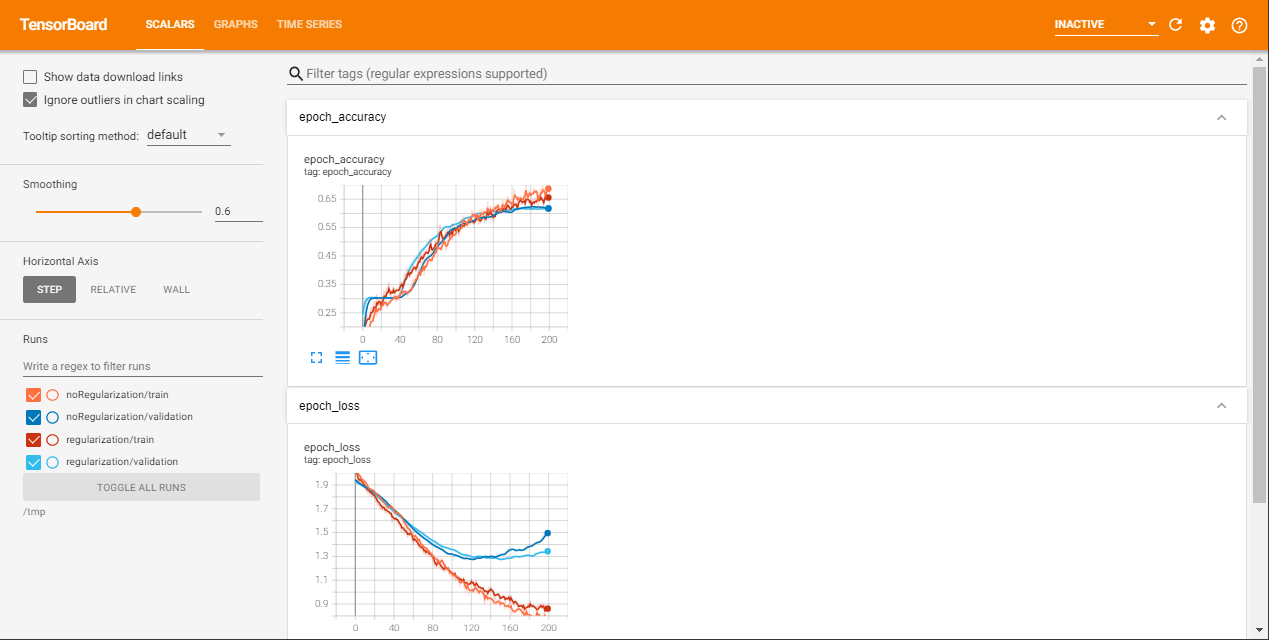